# Algorithm Walk-Through

This notebook will walkthrough the preprocessing steps as well as the ML algorithm training procedure used for the multi-dimensional, multi-output data. 

## Experiment Overview

## Code

### Packages

In [14]:
import sys
sys.path.insert(0, "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/src")

# Standard packages
import numpy as np
import pandas as pd

# Datasets
from data.make_dataset import DataLoader, load_standard_data, load_high_dim_data, load_labels, get_data

# Experiments

# Features
from features.pca_features import transform_all, transform_individual
from features.analysis import get_stats
from sklearn.preprocessing import StandardScaler
from data.make_dataset import ValidationFloats
from features.build_features import run_input_preprocess, run_input_postprocess, run_output_preprocess, run_output_postprocess, run_split

# ML Models
from sklearn.model_selection import train_test_split
from models.baseline import train_rf_model
import statsmodels.api as smi

# Visualization
from visualization.visualize import plot_mo_stats, plot_geolocations, get_depth_labels
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
class DataParams:
    region = 'na'

class ProcessParams:
    n_components = 10
    valid_split = 0.2
    input_std = "before"
    pca_seed = 123
    bootstrap_seed = 123
    std_ouputs = False


In [16]:
def run_experiment():
    
    # Load Data
    dataset = get_data(DataParams)
    print("Input:\n", dataset['ytrain'].min().min(), dataset['ytrain'].max().max())
        
    # Run Inputs Preprocessing
    dataset = run_input_preprocess(ProcessParams, dataset)
    
    # Run Outputs Preprocessing
    # Train Test Split
    dataset = run_split(ProcessParams, dataset)
    
    
    
    
    # Run Inputs PostProcessing
    if ProcessParams.input_std == 'after':
        dataset = run_input_postprocess(ProcessParams, dataset)
    
    # Run Outputs Post Processing
    dataset = run_output_postprocess(ProcessParams, dataset)
    
    print("Output:\n", dataset['ytrain'].min().min(), dataset['ytrain'].max().max())
    return dataset

In [17]:
REGION = 'stg' # 'na'
REGION_FLOAT = 3902121 # 6901486
MODEL = 'lr'

class DataParams:
    region = REGION

class ProcessParams:
    n_components = 5
    valid_split = 0.2
    input_std = "before"
    pca_seed = 123
    bootstrap_seed = 123
    std_ouputs = True

dataset = run_experiment()

region = DataParams.region

print('Training:')
print(dataset['Xtrain'].shape, dataset['ytrain'].shape)
print('Validation:')
print(dataset['Xvalid'].shape, dataset['yvalid'].shape)
print('Testing:')
print(dataset['Xtest'].shape, dataset['ytest'].shape)

Input:
 3.9999998989515e-05 0.0042500000687937
Output:
 -5.28703036321553 8.299632921300223
Training:
(1082, 33) (1082, 276)
Validation:
(271, 33) (271, 276)
Testing:
(133, 33) (133, 276)


---
### 5 - Train ML Model

In [18]:
from models.baseline import (
    train_glm_model, 
    train_gp_model, 
    train_mlp_model, 
    train_lr_model, 
    train_mo_rf_model, 
    train_ridge_lr_model,
    train_stack_model
)

In [20]:
def save_model(model, save_name):
    # model path
    MODEL_PATH = "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/models/control/"
    
    # save model
    from joblib import dump
    dump(model, MODEL_PATH + save_name + '.joblib')
    return None

def load_model(save_name):
    # model path
    MODEL_PATH = "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/models/control/"
    
    # save model
    from joblib import load
    model = load(MODEL_PATH + save_name + '.joblib')
    return model

#### 5.1 - Ridge Regression

In [21]:
rf_params = {
    "n_estimators": 100,
    "criterion": "mse",
    "n_jobs": -1,
    "random_state": 123,
    "warm_start": False,
    "verbose": 1,
}

In [22]:
model_name = MODEL

# train model
if model_name == 'lr':
    model = train_ridge_lr_model(dataset['Xtrain'], dataset['ytrain'])
elif model_name == 'rf':
     model = train_rf_model(dataset['Xtrain'], dataset['ytrain'], rf_params)
else:
    raise ValueError

# save model
save_model(model, f"{model_name}_{DataParams.region}")

#### 5.3 - (3-Layer) MultiPerceptron Model

In [13]:
model_name = 'mlp'

# model params
mlp_kwargs = {
    "hidden_layer_sizes": (50, 100, 300, 276),
    "activation": 'relu',
    "solver": "adam",
    "batch_size": 100,
    "learning_rate": "adaptive",
    "max_iter": 1_000,
    "random_state": 123,
    "early_stopping": False,
    "verbose": 0,
    "validation_fraction": 0.1,
    "tol": 1e-7,
}


# train model
model = train_mlp_model(
    dataset['Xtrain'], 
    dataset['ytrain'], 
    params=mlp_kwargs
)

# save model
save_model(model, f"{model_name}_{DataParams.region}")

#### 5.4 - MO Random Forest Model

In [ ]:
model_name = 'morf'

# RF params
rf_params = {
    "n_estimators": 1_500,
    "criterion": "mse",
    "n_jobs": -1,
    "random_state": 123,
    "warm_start": False,
    "verbose": 1,
}

# train model
model = train_rf_model(dataset['Xtrain'], dataset['ytrain'], params=rf_params)

# save model
save_model(model, f"{model_name}_{DataParams.region}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 1194 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   36.8s finished


Training time: 37.416 secs.


#### 5.2 - Stacked Model (LR + RF)

In [10]:
model_name = 'lr_rf'

# train model
model = train_stack_model(dataset['Xtrain'], dataset['ytrain'], order=('lr', 'rf'), verbose=0, n_jobs=-1)

# save model
save_model(model, f"{model_name}_{DataParams.region}")

#### 5.5 - Gaussian Process (White, ARD, Periodic, Matern32 Kernels)

In [ ]:
model_name = 'morf'

# GP params
gp_params = {
    "normalize_y": True,  # good standard practice 
    "random_state": 123,  # reproducibility
    "n_restarts_optimizer": 10,  # good practice (avoids local minima)
}

# train GP model
model = train_gp_model(dataset['Xtrain'], dataset['ytrain'], params=gp_params)

# save model
save_model(model, f"{model_name}_{DataParams.region}")

(-5.28703036321553, 8.299632921300223)

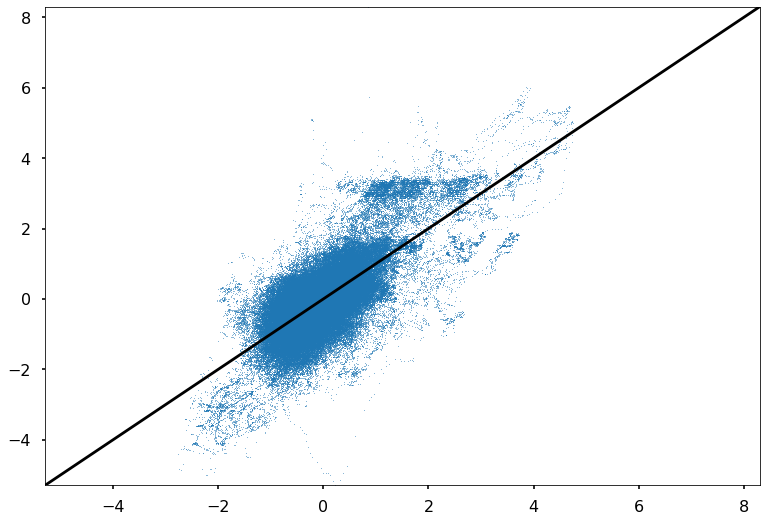

In [25]:
ypred = model.predict(dataset['Xtrain'])

min_lim = np.min(np.concatenate((ypred, dataset['ytrain'])))
max_lim = np.max(np.concatenate((ypred, dataset['ytrain'])))


plt.scatter(ypred, dataset['ytrain'], s=0.1)
plt.plot(np.linspace(min_lim, max_lim), np.linspace(min_lim, max_lim), color='black', zorder=3)
plt.xlim([min_lim, max_lim])
plt.ylim([min_lim, max_lim])

In [26]:
stat_mod = smi.OLS(ypred.ravel(), dataset['ytrain'].values.ravel())

res = stat_mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.524
Model:                            OLS   Adj. R-squared (uncentered):              0.524
Method:                 Least Squares   F-statistic:                          3.289e+05
Date:                Mon, 27 Apr 2020   Prob (F-statistic):                        0.00
Time:                        18:06:35   Log-Likelihood:                     -2.1329e+05
No. Observations:              298632   AIC:                                  4.266e+05
Df Residuals:                  298631   BIC:                                  4.266e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [27]:
# each level
each_level = False

stats = get_stats(ypred, dataset['ytrain'], each_level=each_level)

stats

,mae,mse,rmse,r2
0,0.521483,0.475935,0.475935,0.524065


Then we can look at the statistics for each level.

In [29]:
class PlotParams:
    model = MODEL
    region = REGION
#     validation_float = 

In [30]:
each_level = True

stats_df = get_stats(ypred, dataset['ytrain'], each_level=each_level)

stats_df.head()

,mae,mse,rmse,r2
0,0.529779,0.540059,0.734887,0.459941
1,0.519471,0.500952,0.707779,0.499048
2,0.520429,0.495406,0.703850,0.504594
3,0.522859,0.493923,0.702796,0.506077
4,0.520367,0.486153,0.697247,0.513847


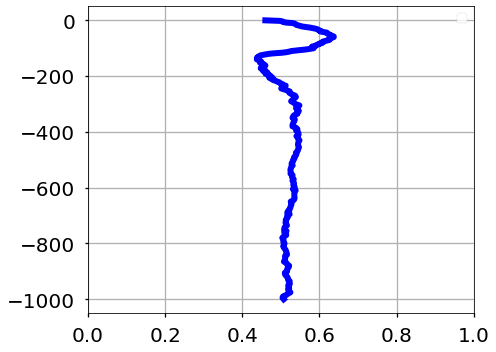

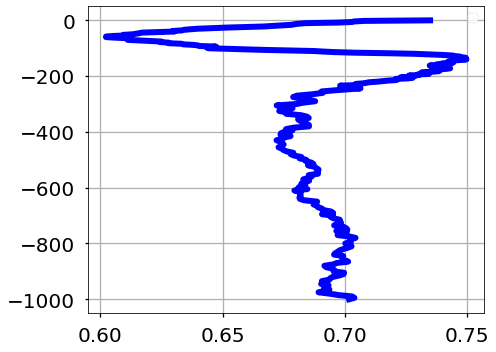

In [31]:
statistic = 'r2'

plt.style.use('seaborn-talk')
plot_mo_stats(stats_df, stat='r2', save_name=f'{REGION}_train_{MODEL}')
plot_mo_stats(stats_df, stat='rmse', save_name=f'{REGION}_train_{MODEL}')

In [32]:
ypred = model.predict(dataset['Xvalid'])

In [33]:
def plot_scatter(df, plot_config):
    
    import seaborn as sns
    
    plt.figure(figsize=(10,10))
    g = sns.jointplot(x="Predictions", y="Test", data=df, kind='reg', scatter=False)
    pts = g.ax_joint.scatter(x='Predictions', y='Test', c='n_cycle', data=df, cmap='winter', s=10)
    plt.colorbar(pts)
    plt.tight_layout()
    plt.legend([fr'R$^2$: {plot_config['r2']:.3f}'], fontsize=20)
    plt.savefig(SAVE_PATH + f'stg_{plot_config["data"]}_m{plot_config["model_name"]}_f{plot_config["float_name"]}_time' + '.png')
    plt.show()
    pass

SyntaxError: invalid syntax (<ipython-input-33-15e29e239bfd>, line 10)

##### Get R2 Values

In [373]:
predictions = pd.DataFrame(ypred, columns=get_depth_labels())
validations = pd.DataFrame(dataset['yvalid'].values, columns=get_depth_labels())

# create time series
predictions = pd.melt(
    predictions, var_name="Depth", value_name="Predictions"
)
validations = pd.melt(validations, var_name="Depth", value_name="Labels")

y_scatter = pd.merge(predictions, validations)

y_scatter.head()

,Depth,Predictions,Labels
0,0,-6.099962,-5.750874
1,0,-6.099962,-7.024289
2,0,-6.099962,-6.105754
3,0,-6.099962,-5.722965
4,0,-6.099962,-7.581100


##### Plot Data

<Figure size 720x1080 with 0 Axes>

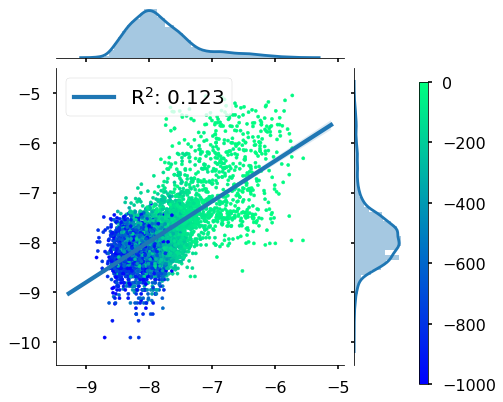

In [374]:
plot_config = dict()

plot_config['region'] = DataParams.region
plot_config['model'] = model_name
plot_config['float'] = 'test' 

# y_val_scat = get_scatter_validation(ypred, plot_config)

plot_config['r2'] = r2_score(y_scatter['Predictions'], y_scatter['Labels'])


plot_scatter(y_scatter.sample(5_000), plot_config)

In [394]:
each_level = True

stats_df = get_stats(ypred, dataset['yvalid'], each_level=each_level)

stats_df.head()

,mae,mse,rmse,r2
0,0.093128,0.023003,0.151669,0.709351
1,0.085847,0.018484,0.135957,0.757591
2,0.080686,0.014418,0.120076,0.798835
3,0.079242,0.013651,0.116836,0.804536
4,0.078813,0.013175,0.114781,0.804788


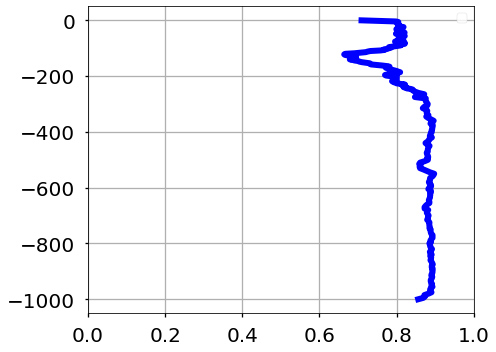

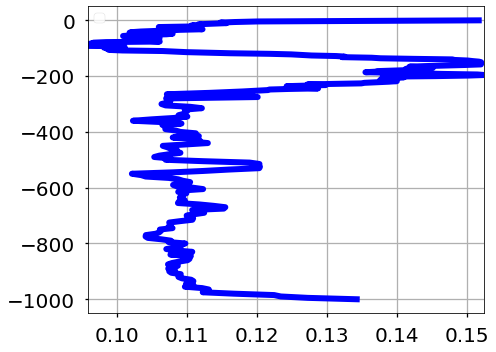

In [395]:
statistic = 'r2'
plt.style.use('seaborn-talk')
plot_mo_stats(stats_df, stat='r2', save_name='stg_test_rf')
plot_mo_stats(stats_df, stat='rmse', save_name='stg_test_rf')

In [192]:
predictions = pd.DataFrame(ypred, columns=get_depth_labels())
validations = pd.DataFrame(dataset['yvalid'].values, columns=get_depth_labels())

# create time series
predictions = pd.melt(
    predictions, var_name="Depth", value_name="Predictions"
)
validations = pd.melt(validations, var_name="Depth", value_name="Test")

y_scatter = pd.merge(predictions, validations)

y_scatter.head()

,Depth,Predictions,Test
0,0,-5.761626,-5.750874
1,0,-5.761626,-7.024289
2,0,-5.761626,-6.105754
3,0,-5.761626,-5.722965
4,0,-5.761626,-7.581100


In [186]:
y_scatter.sample(n=1_000, random_state=1).shape, y_scatter.shape

((1000, 3), (90302784, 3))

<Figure size 720x720 with 0 Axes>

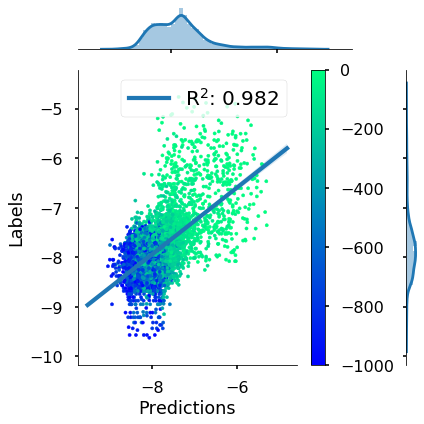

In [195]:
SAVE_PATH = "/home/emmanuel/figures/ml4ocn/"
plot_config = dict()
plot_config['region'] = region
plot_config['r2'] = 0.982
plot_config['model'] = model_name
plot_config['float'] = 3902123
plot_config['data'] = 'Labels'

# y_val_scat = get_scatter_validation(ypred, plot_config)
plot_scatter(y_scatter.sample(n=5_000, random_state=1), plot_config)

In [162]:
ypred.columns.values = depth_labels

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [159]:
ypred.shape

(572, 276)

In [17]:
ypred.shape, dataset['yvalid'].shape

((572, 276), (572, 276))

(9.99999974737875e-06, 0.00908999983221292)

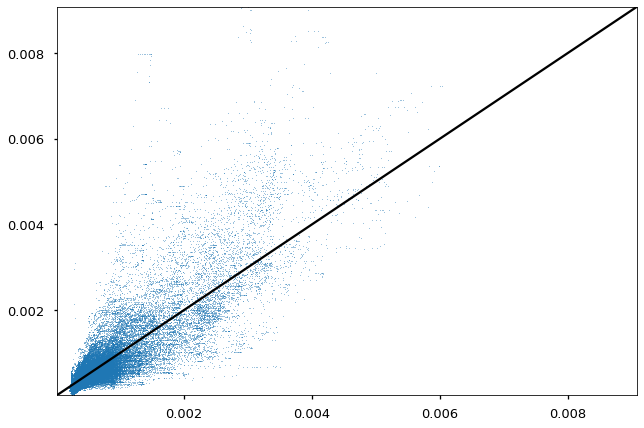

In [18]:
min_lim = np.min(np.concatenate((ypred, dataset['yvalid'])))
max_lim = np.max(np.concatenate((ypred, dataset['yvalid'])))


plt.scatter(ypred, dataset['yvalid'], s=0.1)
plt.plot(np.linspace(min_lim, max_lim), np.linspace(min_lim, max_lim), color='black', zorder=3)
plt.xlim([min_lim, max_lim])
plt.ylim([min_lim, max_lim])

In [19]:
dataset['yvalid'].shape

(572, 276)

In [20]:
stat_mod = smi.OLS(ypred.ravel(), dataset['yvalid'].values.ravel())

res = stat_mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.851
Model:                            OLS   Adj. R-squared (uncentered):              0.851
Method:                 Least Squares   F-statistic:                          8.999e+05
Date:                Mon, 27 Jan 2020   Prob (F-statistic):                        0.00
Time:                        16:09:01   Log-Likelihood:                      1.0674e+06
No. Observations:              157872   AIC:                                 -2.135e+06
Df Residuals:                  157871   BIC:                                 -2.135e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

((36708,), (74796,))

In [79]:
each_level = True

stats_df = get_stats(ypred.ravel(), dataset['ytest'].values.ravel(), each_level=each_level)

stats_df.head()

,mae,mse,rmse,r2
0,0.000041,2.374942e-08,0.000154,0.444236


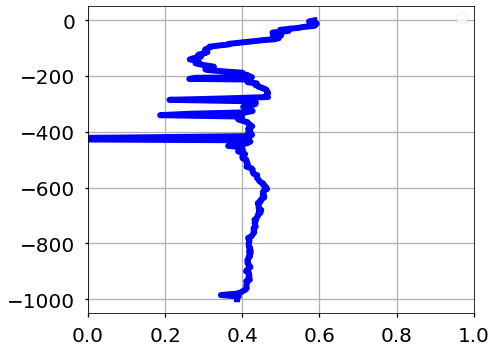

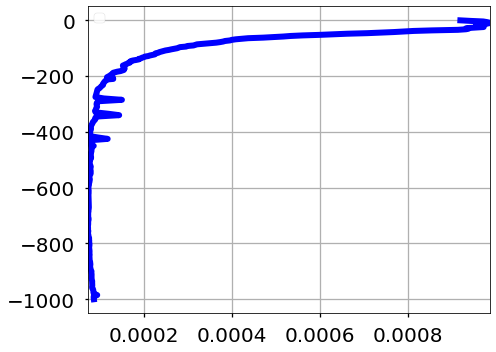

In [22]:
statistic = 'r2'
plt.style.use('seaborn-talk')
plot_mo_stats(stats_df, stat='r2', save_name='stg_test_lr')
plot_mo_stats(stats_df, stat='rmse', save_name='stg_test_lr')

In [76]:
ypred = model.predict(dataset['Xvalid'])

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.1s
[Parallel(n_jobs=28)]: Done 394 tasks      | elapsed:    0.2s
[Parallel(n_jobs=28)]: Done 744 tasks      | elapsed:    0.4s
[Parallel(n_jobs=28)]: Done 1000 out of 1000 | elapsed:    0.5s finished


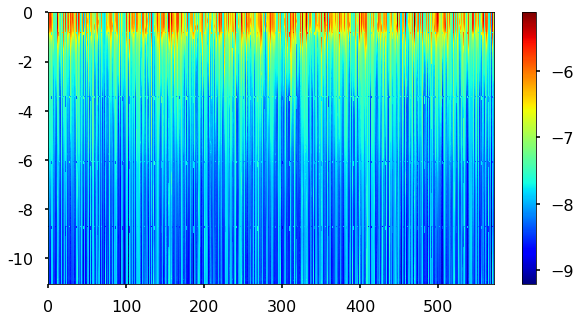

In [77]:
plot_config = dict()
plot_config['region'] = region
plot_config['float'] = 6901486
plot_config['model'] = model_name
plot_config['data'] = 'validation'

# dat = get_valid_floats(plot_config)
plot_profiles(ypred, plot_config)

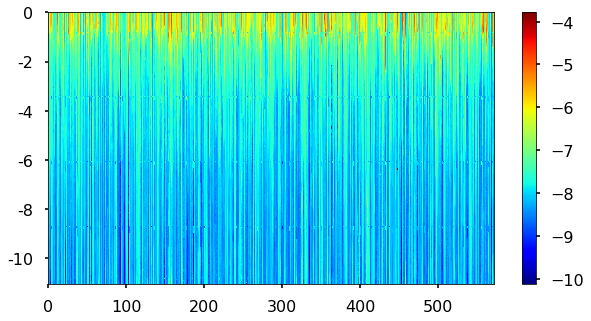

In [78]:
plot_config = dict()
plot_config['region'] = region
plot_config['float'] = 6901486
plot_config['model'] = model_name
plot_config['data'] = 'yvalid'

# dat = get_valid_floats(plot_config)
plot_profiles(dataset['yvalid'], plot_config)

In [389]:
ypred = model.predict(dataset['Xtest'])

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.1s
[Parallel(n_jobs=28)]: Done 394 tasks      | elapsed:    0.1s
[Parallel(n_jobs=28)]: Done 744 tasks      | elapsed:    0.3s
[Parallel(n_jobs=28)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [366]:
def get_scatter_validation(df, df_test, plot_config):
    
    # initialize class
    valid_getter = ValidationFloats(plot_config['region'])

    # get validation floats
    valid_getter.get_validation_floats(plot_config['region'])
    
    # get timeseries
    df = valid_getter.get_validation_res(df_test, df, validation_float=plot_config['float'])
    
    return df


def df_2_xr(data):
    
    # create multiindex data
    data = data.set_index(['n_cycle', 'Depth'])
    
    # convert to xarray
    data = data.to_xarray()
    
    return data
def plot_profiles(xr_data, plot_config):
    
    import matplotlib.colors as colors
    
    # Convert to xarray
    SAVE_PATH = "/home/emmanuel/figures/ml4ocn/"
    fig, ax = plt.subplots(figsize=(10,5))
    if plot_config['robust'] == True:
        xr_data.T.plot.pcolormesh(ax=ax, cmap='jet', cbar_kwargs={'label': ''}, robust=plot_config['robust'])
    else:
        xr_data.T.plot.pcolormesh(
            ax=ax, 
            cmap='jet', 
            cbar_kwargs={'label': ''}, 
            norm=colors.LogNorm(vmin=plot_config['vmin'], vmax=plot_config['vmax']), 
            vmin=plot_config['vmin'], 
            vmax=plot_config['vmax'], 
            robust=False
        )
    ax.set_xlabel('')
    ax.set_ylabel('')
#     ax.set_yticklabels(get_depth_labels())
    plt.tight_layout()
    fig.savefig(SAVE_PATH + f"{plot_config['region']}_y_{plot_config['data']}_heatmap_{plot_config['float']}_pred_{plot_config['model']}")
    pass



**NA**
* 6901486 
* 3902123

**STG**
* 6901472
* 3902121

In [73]:
ypred_

array([[0.03241515, 0.03249627, 0.03277638, ..., 0.02021938, 0.02021231,
        0.02020567],
       [0.03258741, 0.03265431, 0.03296169, ..., 0.02002968, 0.02001938,
        0.02001338],
       [0.03256133, 0.03264498, 0.03292198, ..., 0.02000669, 0.01997411,
        0.01996073],
       ...,
       [0.03691499, 0.03649553, 0.036584  , ..., 0.02367047, 0.02366361,
        0.02364842],
       [0.03628594, 0.0360738 , 0.03612746, ..., 0.02339059, 0.0234753 ,
        0.02338352],
       [0.03632206, 0.03613055, 0.03616642, ..., 0.02347837, 0.02354185,
        0.0234447 ]])

In [367]:
ypred_ = dataset['out_post_trans'].inverse_transform(ypred)
ytest_ = dataset['out_post_trans'].inverse_transform(dataset['ytest'])

In [237]:
ypred_.shape

(133, 276)

In [75]:
plot_config = dict()
plot_config['region'] = DataParams.region
plot_config['r2'] = 0.9
plot_config['model'] = model_name
plot_config['float'] = 6901486
plot_config['data'] = 'Predictions'

y_val_scat = get_scatter_validation(ypred_, ytest_, plot_config)
y_val_scat.iloc[:, 2:].describe()

(133, 2) (133, 276)
0.0001116734674130233 6901472.0 0.0001300000003539031 6901472.0


,Predictions,Labels
count,29808.000000,29808.000000
mean,0.000296,0.000330
std,0.000128,0.000222
min,0.000171,0.000170
25%,0.000197,0.000220
50%,0.000228,0.000250
75%,0.000429,0.000466
max,0.000596,0.009760


In [76]:
y_val_scat.Predictions.min()

0.0001707489683609274

(162, 2) (162, 276)
0.0001433435529995995 6901486.0 0.00016999999934341794 6901486.0


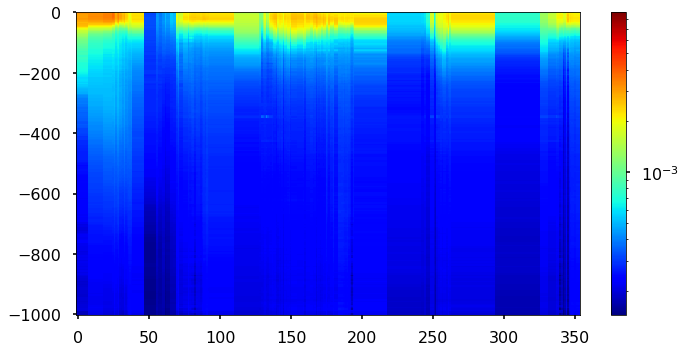

In [369]:
plot_config = dict()
plot_config['region'] = DataParams.region
plot_config['r2'] = 0.9
plot_config['model'] = model_name

plot_config['float'] = 6901486
plot_config['data'] = 'Predictions'
plot_config['robust'] = False


y_val_scat = get_scatter_validation(ypred_, ytest_, plot_config)
plot_config['vmin'] = np.minimum(y_val_scat.Predictions.min(), y_val_scat.Labels.min())
plot_config['vmax'] = np.maximum(y_val_scat.Predictions.max(), y_val_scat.Labels.max())
# print(y_val_scat.head())
# y_val_scat.iloc[:, 3:] = y_val_scat.iloc[:, 3:]
y_val_scat = df_2_xr(y_val_scat)
plot_profiles(y_val_scat.Predictions, plot_config)

In [122]:
SAVE_PATH = "/home/emmanuel/figures/ml4ocn/"


def plot_scatter(df, plot_config):
    
    import seaborn as sns
    
    plt.figure(figsize=(10,15))
    
    
    g = sns.jointplot(x="Predictions", y="Labels", data=df, kind='reg', scatter=False, truncate=True, logx=False)
#     g.plot_marginals(sns.distplot, hist=True, kde=True, color='blue')

    plt.legend([fr'R$^2$: {plot_config["r2"]:.3f}'], fontsize=20, loc='upper left', )
    plt.xlabel('')
    plt.ylabel('')
    pts = g.ax_joint.scatter(x='Predictions', y='Labels', c='Depth', data=df, cmap='winter', s=10)
    g.ax_joint.set_xscale('log')
    g.ax_joint.set_yscale('log')
#     g.ax_marg_x.set_xscale('log')
#     g.ax_marg_y.set_yscale('log')
    # get the mapping from the scatter
    PCM=g.ax_joint.get_children()[1]
    
    # Make New axis for the bar
    cbar_ax = g.fig.add_axes([1.01, .1, .02, .7])
    cb = plt.colorbar(PCM, cax=cbar_ax)
#     plt.colorbar(pts, orientation='horizontal')
#     cbar_ax = g.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
#     plt.colorbar(cax=cbar_ax)
#     outpathc = g.get_children()[3] 
#TODO -- don't assume PathCollection is 4th; at least check type

#     plt.colorbar(mappable=outpathc, cax=cbar_ax)

#     plt.tight_layout()
    
#     plt.show()
    g.savefig(SAVE_PATH + f'{plot_config["region"]}_m{plot_config["model"]}_f{plot_config["float"]}_depth' + '.png')
    plt.show()
    pass

In [143]:
y_val_scat.describe()

,n_cycle,Predictions,Labels
count,6900.000000,6900.000000,6900.000000
mean,13.840000,0.000222,0.000260
std,7.449996,0.000107,0.000105
min,1.000000,0.000112,0.000130
25%,8.000000,0.000141,0.000180
50%,14.000000,0.000165,0.000200
75%,20.000000,0.000335,0.000369
max,26.000000,0.000441,0.000520


In [391]:
ypred_ = dataset['out_post_trans'].inverse_transform(ypred)
ytest_ = dataset['out_post_trans'].inverse_transform(dataset['ytest'])

In [397]:
plot_config = dict()

plot_config['region'] = DataParams.region
plot_config['model'] = model_name
plot_config['float'] = 3902121 
plot_config['slope'] = 0.9773

y_val_scat = get_scatter_validation(ypred_, ytest_, plot_config)

plot_config['vmin'] = np.minimum(y_val_scat.Predictions.min(), y_val_scat.Labels.min())
plot_config['vmax'] = np.maximum(y_val_scat.Predictions.max(), y_val_scat.Labels.max())
plot_config['r2'] = r2_score(np.log10(y_val_scat['Predictions']), np.log10(y_val_scat['Labels']))
plot_config['mapd'] = np.median(np.abs((y_val_scat['Predictions']) - (y_val_scat['Labels'])) / (y_val_scat['Labels']))

y_val_scat['Predictions'] = y_val_scat['Predictions']
y_val_scat['Labels'] = y_val_scat['Labels']

(133, 2) (133, 276)
0.0001116734674130233 6901472.0 0.0001300000003539031 6901472.0


In [394]:
f"{plot_config['mapd']:.2%}"

'18.47%'

In [395]:
y_val_scat.to_csv(SAVE_PATH + 'stg_results.csv')

In [396]:
stat_mod = smi.OLS(np.log10(y_val_scat['Labels']), np.log10(y_val_scat['Predictions']))

res = stat_mod.fit()
r2_val = res.rsquared
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Labels   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.883e+07
Date:                Wed, 05 Feb 2020   Prob (F-statistic):                        0.00
Time:                        14:26:46   Log-Likelihood:                          11917.
No. Observations:                6900   AIC:                                 -2.383e+04
Df Residuals:                    6899   BIC:                                 -2.382e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [269]:
line = np.logspace(-4, -2, 100)

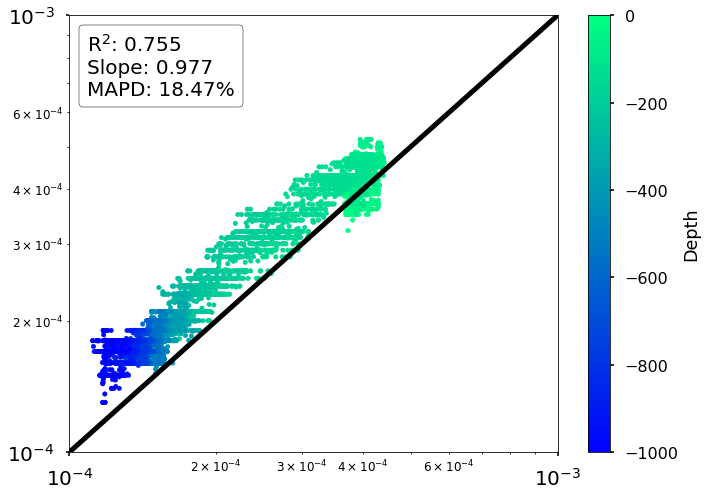

In [399]:
from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots(figsize=(10,7))
y_val_scat.plot.scatter(ax=ax, x='Predictions', y='Labels', c='Depth', logx=True, logy=True, cmap='winter')
ax.plot(line, line, linewidth=5, color='black')

at = AnchoredText(f"R$^2$: {plot_config['r2']:.3f}\nSlope: {plot_config['slope']:.3f}\nMAPD: {plot_config['mapd']:.2%}",
                  prop=dict(size=15, fontsize=20), frameon=True,
                  loc='upper left',
                  
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
# ax.annotate([fr'R$^2$: {plot_config["r2"]:.3f}\n', xy=(-12, -12), xycoords='axes points',
#             size=14, ha='right', va='top',
#             bbox=dict(boxstyle='round', fc='w'))
ax.autoscale(enable=True, axis='both', tight=True)
ax.set_xlim(0.0001, 0.001)
ax.set_ylim(0.0001, 0.001)
ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid(True, ls="-", color='gray')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=12)
# plt.legend([fr'R$^2$: {plot_config["r2"]:.3f}'], fontsize=20, loc='upper left', )
plt.tight_layout()
fig.savefig(SAVE_PATH + f'{plot_config["region"]}_m{plot_config["model"]}_f{plot_config["float"]}_depth' + '.png')
plt.show()

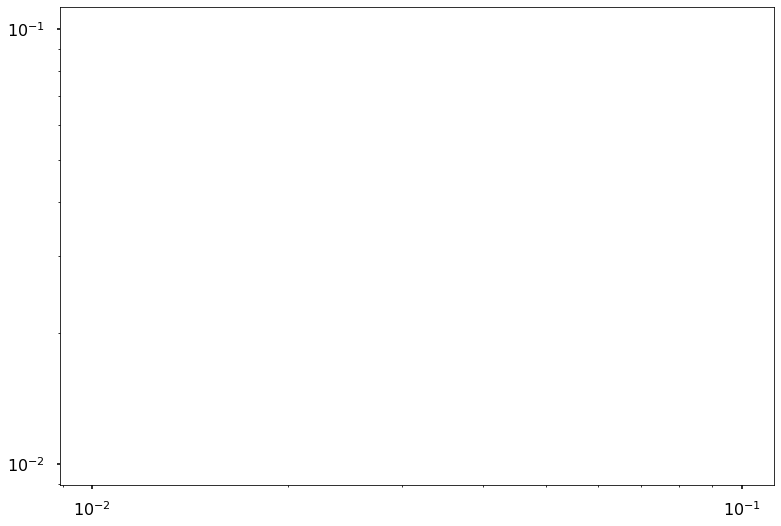

In [196]:
fig, ax = plt.subplots()

ax.scatter(y_val_scat.Predictions, y_val_scat.Labels, c=y_val_scat.Depth)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [190]:
y_val_scat.head()

,n_cycle,Depth,Predictions,Labels
0,3.0,0,0.003238,0.003690
1,12.0,0,0.003148,0.003060
2,24.0,0,0.003298,0.003780
3,25.0,0,0.003612,0.003905
4,26.0,0,0.003370,0.003920


AttributeError: module 'seaborn' has no attribute 'scatter'

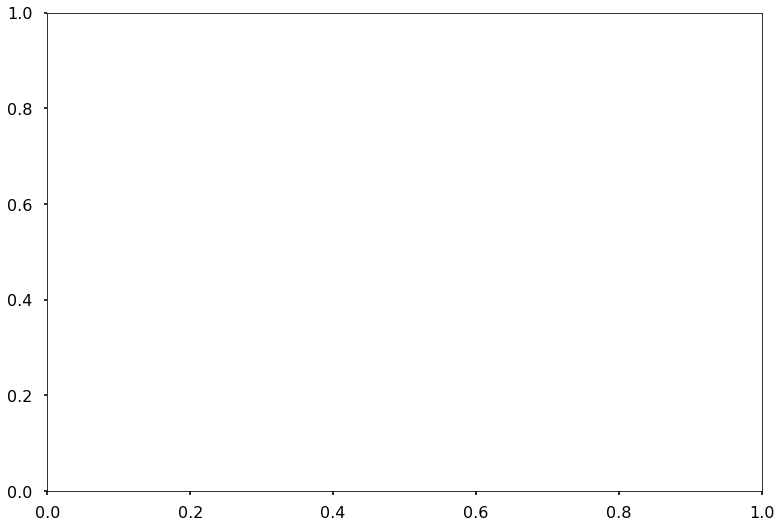

In [188]:
import seaborn as sns

mybins=np.logspace(0,np.log(100),100)

# Define plot
fig, ax = plt.subplots()
# g= sns.jointplot(x="Predictions", y="Labels", data=y_val_scat, kind='reg', scatter=False, logx=False)
g = sns.scatter(
    ax=ax,
    x="Predictions", 
    y="Labels", 
    data=y_val_scat.iloc[:100,:], 
    c='Depth'
#     xlim=[plot_config['vmin'], plot_config['vmax']],
#     ylim=[plot_config['vmin'], plot_config['vmax']]
)
# g = sns.JointGrid(x="Predictions", y="Labels", data=y_val_scat,)
# g.plot_marginals(sns.distplot, hist=True, kde=False, color='blue')
# g.plot_joint(g.ax_joint.scatter,)
# g.plot
# ax = g.ax_joint
# plt.xscale('log')
ax.set_xscale('log')
ax.set_yscale('log')
# g.ax_joint.set_yscale('log')
# ax.set_yscale('log')
# g.ax_marg_x.set_xscale('log')
# g.ax_marg_y.set_yscale('log')

(133, 2) (133, 276)
0.0001116734674130233 6901472.0 0.0001300000003539031 6901472.0


<Figure size 720x1080 with 0 Axes>

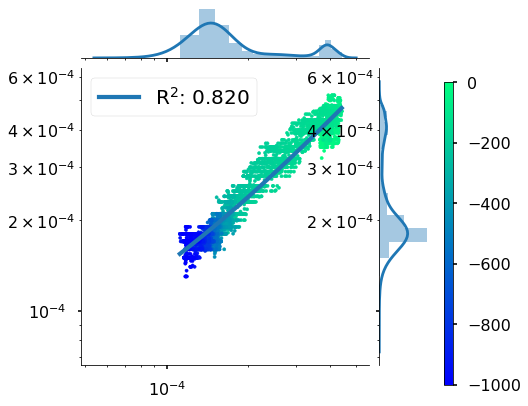

In [123]:
plot_config = dict()

plot_config['region'] = DataParams.region
plot_config['model'] = model_name
plot_config['float'] = 3902121 

y_val_scat = get_scatter_validation(ypred_, ytest_, plot_config)
plot_config['r2'] = r2_score(y_val_scat['Predictions'], y_val_scat['Labels'])
# y_val_scat.iloc[:, 2:] = np.exp(y_val_scat.iloc[:, 2:])
# plot_config['r2'] = r2_score(y_val_scat['Predictions'], y_val_scat['Labels'])


plot_scatter(y_val_scat, plot_config)

In [57]:
y_val_scat.iloc[:, 2:].describe()

,Predictions,Labels
count,6900.000000,6900.000000
mean,0.025229,0.027252
std,0.005063,0.004608
min,0.019215,0.020526
25%,0.021274,0.023642
50%,0.022744,0.024749
75%,0.030956,0.032292
max,0.034900,0.037478


In [41]:
from sklearn.metrics import mean_squared_error, r2_score

In [426]:
mean_squared_error(y_val_scat['Predictions'], y_val_scat['Labels'])
r2_score(y_val_scat['Predictions'], y_val_scat['Labels'])

0.5673513484557717

**NA**
* 6901486 
* 3902123

**STG**
* 6901472
* 3902121

In [436]:
ypred = model.predict(dataset['Xtest'])

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.1s
[Parallel(n_jobs=28)]: Done 394 tasks      | elapsed:    0.1s
[Parallel(n_jobs=28)]: Done 744 tasks      | elapsed:    0.3s
[Parallel(n_jobs=28)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [47]:
SAVE_PATH = "/home/emmanuel/figures/ml4ocn/"
# g = sns.JointGrid('total_bill', 'tip', data,xlim=[1,100],ylim=[0.01,100])
# g.plot_marginals(sns.distplot, hist=True, kde=True, color='blue',bins=mybins)
# g.plot_joint(plt.scatter, color='black', edgecolor='black')
# ax = g.ax_joint
# ax.set_xscale('log')
# ax.set_yscale('log')
# g.ax_marg_x.set_xscale('log')
# g.ax_marg_y.set_yscale('log')

def plot_scatter(df, plot_config):
    
    import seaborn as sns
    
    plt.figure(figsize=(10,15))
    
    # Plot Joint Grid
    g = sns.JointGrid(x="Predictions", y="Labels", data=df,)
    ax = g.ax_joint
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Plot Marginals
    g.plot_marginals(sns.distplot, hist=True, kde=True, color='blue', bins=50)
    
    # Plot Regression
    
    # Plot scatter points
    
#     pts = g.ax_joint.scatter(x='Predictions', y='Labels', c='Depth', data=df, cmap='winter', s=10)
#     pts.set_xscale('log')
#     g = sns.jointplot(x="Predictions", y="Labels", data=df, kind='reg', scatter=False,, logx=True)
# #     g.plot_marginals(sns.distplot, hist=True, kde=True, color='blue')

#     plt.legend([fr'R$^2$: {plot_config["r2"]:.3f}'], fontsize=20, loc='upper left', )
#     plt.xlabel('')
#     plt.ylabel('')
#     pts = g.ax_joint.scatter(x='Predictions', y='Labels', c='Depth', data=df, cmap='winter', s=10)
#     g.ax_joint.set_xscale('log')
#     g.ax_joint.set_yscale('log')
# #     g.ax_marg_x.set_xscale('log')
# #     g.ax_marg_y.set_yscale('log')
#     # get the mapping from the scatter
#     PCM=g.ax_joint.get_children()[1]
    
#     # Make New axis for the bar
#     cbar_ax = g.fig.add_axes([1.01, .1, .02, .7])
#     cb = plt.colorbar(PCM, cax=cbar_ax)
# #     plt.colorbar(pts, orientation='horizontal')
# #     cbar_ax = g.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
# #     plt.colorbar(cax=cbar_ax)
# #     outpathc = g.get_children()[3] 
# #TODO -- don't assume PathCollection is 4th; at least check type

# #     plt.colorbar(mappable=outpathc, cax=cbar_ax)

# #     plt.tight_layout()
    
# #     plt.show()
#     g.savefig(SAVE_PATH + f'{plot_config["region"]}_m{plot_config["model"]}_f{plot_config["float"]}_depth' + '.png')
#     plt.show()
    pass

(133, 2) (133, 276)
0.0192152700873465 6901472.0 0.02052612843666904 6901472.0


<Figure size 720x1080 with 0 Axes>

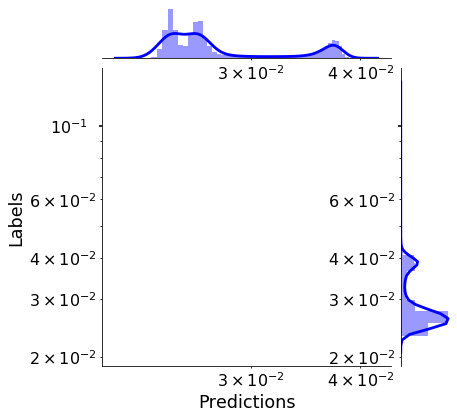

In [48]:
plot_config = dict()

plot_config['region'] = DataParams.region
plot_config['model'] = model_name
plot_config['float'] = 6901472 

y_val_scat = get_scatter_validation(ypred_, ytest_, plot_config)
plot_config['r2'] = r2_score(y_val_scat['Predictions'], y_val_scat['Labels'])
# y_val_scat.iloc[:, 2:] = np.exp(y_val_scat.iloc[:, 2:])
# plot_config['r2'] = r2_score(y_val_scat['Predictions'], y_val_scat['Labels'])


plot_scatter(y_val_scat, plot_config)
# plt.savefig(SAVE_PATH + 'test.png')

In [ ]:
plot_config = dict()
plot_config['region'] = DataParams.region
plot_config['float'] = 6901486 
plot_config['model'] = 'rf'
plot_config['data'] = 'labels'

dat = get_valid_floats(ypred, plot_config)
dat

In [7]:
ypred.shape, dat.shape

NameError: name 'dat' is not defined

In [50]:
def get_valid_floats(ypred, plot_config):
    dat = load_labels(plot_config['region'], training=False)
#     print(dat.shape, ypred.shape)
    if plot_config['data'] == 'prediction':
        dat.iloc[:, 2:] = ypred
    elif plot_config['data'] == 'labels':
        dat.iloc[:, 2:] = np.log(dat.iloc[:, 2:])
    else:
        raise ValueError()
#     print(dat.shape)
    float_data = dat[dat['wmo'] == plot_config['float']].drop(labels=['wmo'], axis=1)
#     print(float_data.shape)
    y_labels = float_data['n_cycle']

    float_data = float_data.iloc[:, 1:]
    
    float_data.index = y_labels
    float_data.columns = get_depth_labels()
    return float_data

def plot_profiles(data, plot_config):
    SAVE_PATH = "/home/emmanuel/figures/ml4ocn/"
    fig, ax = plt.subplots(figsize=(10,5))

    pts = ax.pcolormesh(data.T, cmap='jet')
#     ax.set_yticklabels(get_depth_labels())
    plt.colorbar(pts)
    plt.gca().invert_yaxis()
    plt.savefig(SAVE_PATH + f"{plot_config['region']}_y_{plot_config['data']}_heatmap_{plot_config['float']}_pred_{plot_config['model']}")

In [51]:
# dat.head(), dat.tail()
SAVE_PATH = "/home/emmanuel/figures/ml4ocn/"

In [52]:
dat.head()

,0,-2,-4,-6,-8,-10,-12,-14,-16,-18,...,-955,-960,-965,-970,-975,-980,-985,-990,-995,-1000
n_cycle,,,,,,,,,,,,,,,,,,,,,
3,-5.602129,-5.596723,-5.666487,-5.726028,-5.578031,-5.578031,-5.588670,-5.607564,-5.605975,-5.588670,...,-8.278119,-8.292591,-8.294050,-8.294050,-8.336261,-8.355925,-8.355925,-8.355925,-8.355925,-8.355925
12,-5.789340,-5.795898,-5.754024,-5.732182,-5.675195,-5.675195,-5.697710,-5.747734,-5.710807,-5.678115,...,-8.111728,-8.180721,-8.055558,-8.047190,-8.145630,-8.145630,-7.013116,-7.583904,-8.254829,-8.254829
24,-5.578031,-5.611659,-5.626821,-5.528360,-5.639400,-5.537082,-5.528989,-5.518964,-5.518964,-5.554501,...,-8.111728,-8.111728,-8.111728,-8.111728,-8.178537,-8.294050,-8.294050,-8.294050,-8.294050,-8.294050
25,-5.545497,-5.539116,-5.509038,-5.489478,-5.421616,-5.375198,-5.375198,-5.381699,-5.408132,-5.521461,...,-7.902008,-7.902008,-7.902008,-7.902008,-7.902008,-7.902008,-7.902008,-7.902008,-7.939878,-8.254829
26,-5.541664,-5.570126,-5.572754,-5.511511,-5.444500,-5.551920,-5.524680,-5.489478,-5.527870,-5.521461,...,-8.016787,-8.035445,-8.069152,-8.129363,-8.145630,-8.145630,-8.164797,-8.180721,-8.180721,-8.188104


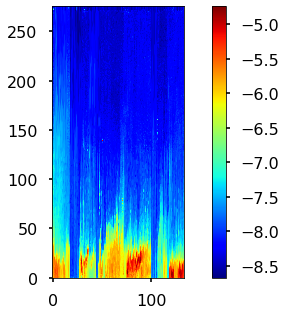

In [53]:
plot_config = dict()
plot_config['region'] = DataParams.region
plot_config['float'] = 6901486 
plot_config['model'] = 'rf'
plot_config['data'] = 'labels'

dat = get_valid_floats(ypred, plot_config)
dat

plot_profiles(dat, plot_config)

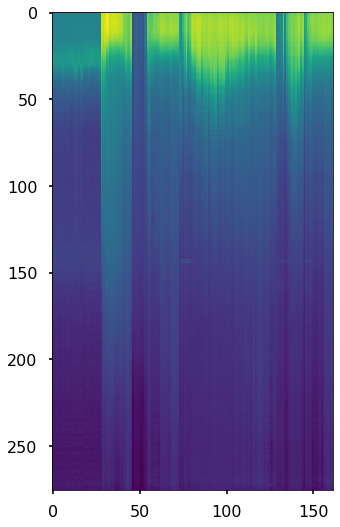

In [70]:
plt.imshow(ypred.T)

In [38]:
from data.make_dataset import load_labels, get_depth_labels


In [39]:
# initialize class
valid_getter = ValidationFloats('stg')

# get validation floats
valid_getter.get_validation_floats('stg')

[6901472, 3902121]

In [40]:
dat = load_labels('stg', training=False)

In [41]:
dat.iloc[:, 2:] = ypred

In [42]:
dat.iloc[:, 2:].shape, ypred.shape

((133, 276), (133, 276))

In [43]:
dat.shape, ypred.shape

((133, 278), (133, 276))

In [44]:
ypred.shape

(133, 276)

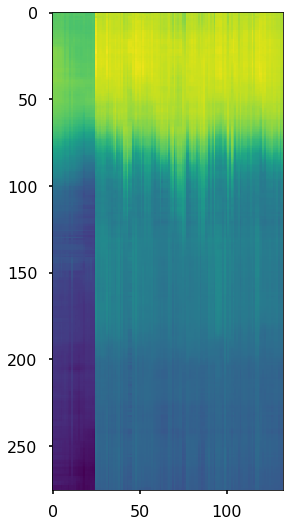

In [45]:
plt.imshow(dat.iloc[:, 2:].T)

In [16]:
# floatname = 6901486 # 6901486 #3902123

float1 = dat[dat['wmo'] == floatname].drop(labels=['wmo'], axis=1)

y_labels = float1['n_cycle']

float1 = float1.iloc[:, 1:]

x_labels = get_depth_labels()

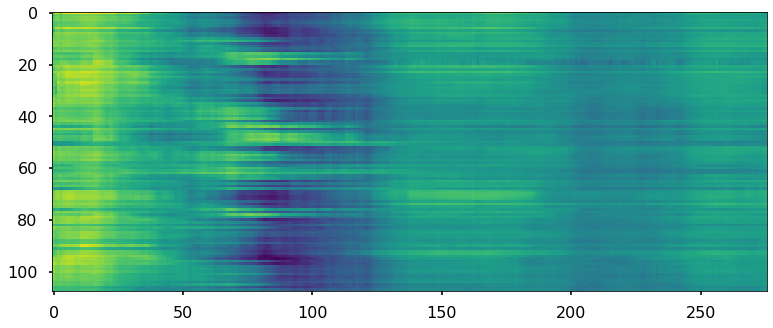

In [17]:
plt.imshow(float1)

In [ ]:
def get_valid_floats():
    dat = load_labels('stg', training=False)

In [ ]:
[6901472, 3902121]

**NA**
* 6901486 
* 3902123

**STG**
[6901472, 3902121]

In [84]:
plot_config = dict()
plot_config['region'] = region
plot_config['float'] = 6901472
plot_config['model'] = model_name
plot_config['data'] = 'label'

dat = get_valid_floats(plot_config)
plot_profiles(dat, plot_config)

ValueError: 

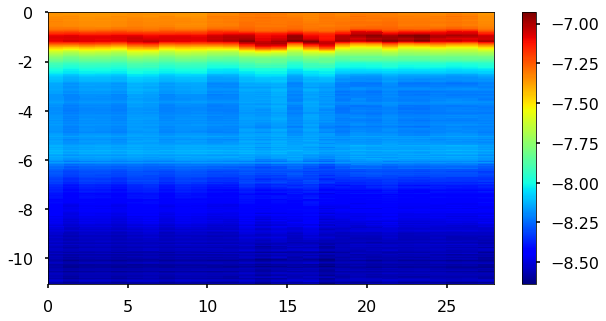

In [75]:
plot_config = dict()
plot_config['region'] = region
plot_config['float'] = 3902123
plot_config['model'] = model_name
plot_config['data'] = 'prediction'

dat = get_valid_floats(plot_config)
plot_profile_predicted(dat, plot_config)

In [55]:
def get_scatter_validation(df, plot_config):
    
    # initialize class
    valid_getter = ValidationFloats(plot_config['region'])

    # get validation floats
    valid_getter.get_validation_floats(plot_config['region'])
    
    # get timeseries
    df = valid_getter.get_validation_res(ypred, dataset['ytest'], 1)
    
    return df

def plot_scatter(df, plot_config):
    
    import seaborn as sns
    
    plt.figure(figsize=(10,10))
    g = sns.jointplot(x="Predictions", y="Test", data=df, kind='reg', scatter=False)
    pts = g.ax_joint.scatter(x='Predictions', y='Test', c='Depth', data=df, cmap='winter', s=10)
    plt.colorbar(pts)
    plt.tight_layout()
#     plt.axes().set_aspect('equal', 'datalim')
    plt.ylabel(plot_config['data'])
    plt.legend([fr"R$^2$: {plot_config['r2']:.3f}"], fontsize=20)
    plt.savefig(SAVE_PATH + f'{plot_config["region"]}_{plot_config["data"]}_m{plot_config["model"]}_f{plot_config["float"]}_time' + '.png')
    plt.show()
    pass

In [58]:
y_val_scat.head()

,n_cycle,Depth,Predictions,Test
0,17.0,0,-7.070274,-7.347102
1,19.0,0,-7.013116,-7.350406
2,20.0,0,-6.897805,-7.353594
3,21.0,0,-6.938214,-7.357767
4,22.0,0,-7.082109,-7.354769


In [63]:
df_multi = y_val_scat.set_index(['n_cycle', 'Depth'])
dat_xr = df_multi.to_xarray()

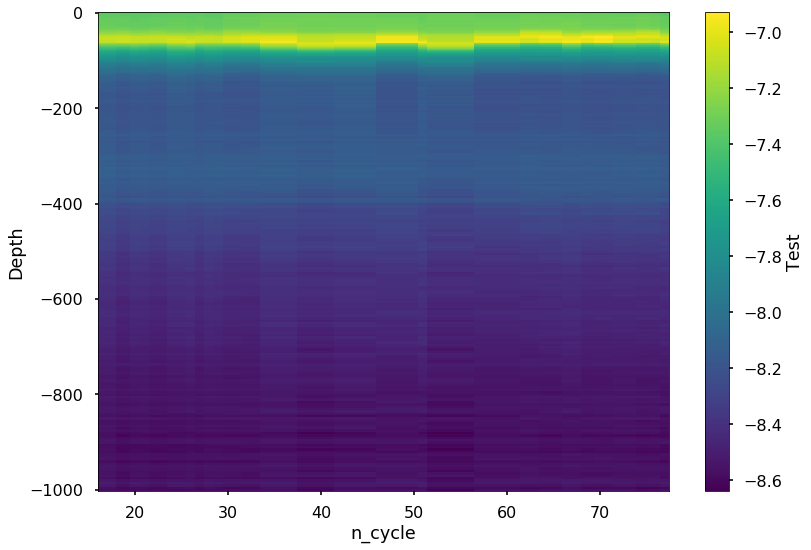

In [67]:
dat_xr.Test.T.plot()

In [61]:
import xarray as xr

In [ ]:
df_multi

In [60]:
df_multi.shape

(7728, 2)

In [ ]:
y_val

In [56]:
plot_config = dict()
plot_config['region'] = DataParams.region
plot_config['r2'] = 0.9
plot_config['model'] = model_name
plot_config['float'] = 3902123
plot_config['data'] = 'Labels'

y_val_scat = get_scatter_validation(ypred, plot_config)
# plot_scatter(y_val_scat, plot_config)

(162, 2) (162, 276)


In [ ]:
# initialize class
valid_getter = ValidationFloats('stg')

# get validation floats
valid_getter.get_validation_floats('stg')

In [111]:


# get timeseries
y_validation = valid_getter.get_validation_res(ypred, dataset['ytest'], 1)

y_validation.head()

(162, 2) (162, 276)


,n_cycle,Depth,Predictions,Test
0,17.0,0,-0.924080,-0.122721
1,19.0,0,-0.847228,-0.153329
2,20.0,0,-0.692187,-0.267439
3,21.0,0,-0.746520,-0.236638
4,22.0,0,-0.939992,-0.152829


In [112]:
stat_mod = smi.OLS(y_validation['Predictions'].ravel(), y_validation['Test'].ravel())

res = stat_mod.fit()
r2_val = res.rsquared
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.020
Model:                            OLS   Adj. R-squared (uncentered):              0.020
Method:                 Least Squares   F-statistic:                              156.6
Date:                Fri, 31 Jan 2020   Prob (F-statistic):                    1.40e-35
Time:                        16:30:04   Log-Likelihood:                         -8775.1
No. Observations:                7728   AIC:                                  1.755e+04
Df Residuals:                    7727   BIC:                                  1.756e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [113]:
model_name = 'rf'
ifloat = 3902123 # 6901486 #3902123


In [105]:
def plot_scatter(df, plot_config):
    
    import seaborn as sns
    
    plt.figure(figsize=(10,10))
    g = sns.jointplot(x="Predictions", y="Test", data=df, kind='reg', scatter=False)
    pts = g.ax_joint.scatter(x='Predictions', y='Test', c='n_cycle', data=df, cmap='winter', s=10)
    plt.colorbar(pts)
    plt.tight_layout()
    plt.legend([fr'R$^2$: {plot_config['r2']:.3f}'], fontsize=20)
    plt.savefig(SAVE_PATH + f'stg_{plot_config["data"]}_m{plot_config["model_name"]}_f{plot_config["float_name"]}_time' + '.png')
    plt.show()
    pass

In [109]:
plot_scatter(y_validation)

NameError: name 'y_validation' is not defined

<Figure size 720x720 with 0 Axes>

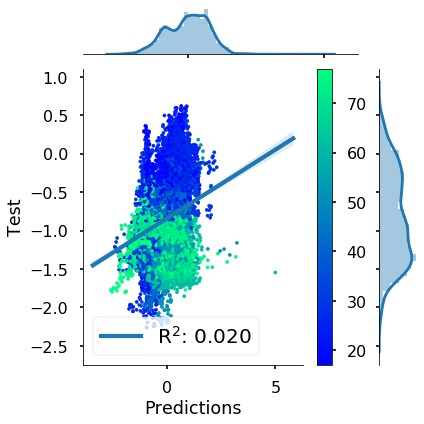

In [115]:
plt.figure(figsize=(10,10))
g = sns.jointplot(x="Predictions", y="Test", data=y_validation, kind='reg', scatter=False)
pts = g.ax_joint.scatter(x='Predictions', y='Test', c='n_cycle', data=y_validation, cmap='winter', s=10)
plt.colorbar(pts)
plt.tight_layout()
plt.legend([fr'R$^2$: {r2_val:.3f}'], fontsize=20)
plt.savefig(SAVE_PATH + f'stg_valid_m{model_name}_f{ifloat}_time' + '.png')
plt.show()

<Figure size 720x720 with 0 Axes>

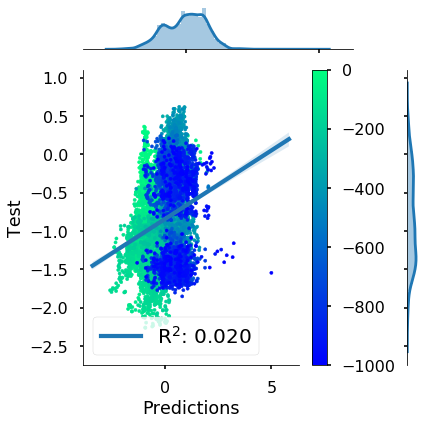

In [116]:
plt.figure(figsize=(10,10))
g = sns.jointplot(x="Predictions", y="Test", data=y_validation, kind='reg', scatter=False)
pts = g.ax_joint.scatter(x='Predictions', y='Test', c='Depth', data=y_validation, cmap='winter', s=10)
plt.colorbar(pts)
plt.tight_layout()
plt.legend([fr'R$^2$: {r2_val:.3f}'], fontsize=20)
plt.savefig(SAVE_PATH + f'stg_valid_m{model_name}_f{ifloat}_depth' + '.png')
plt.show()

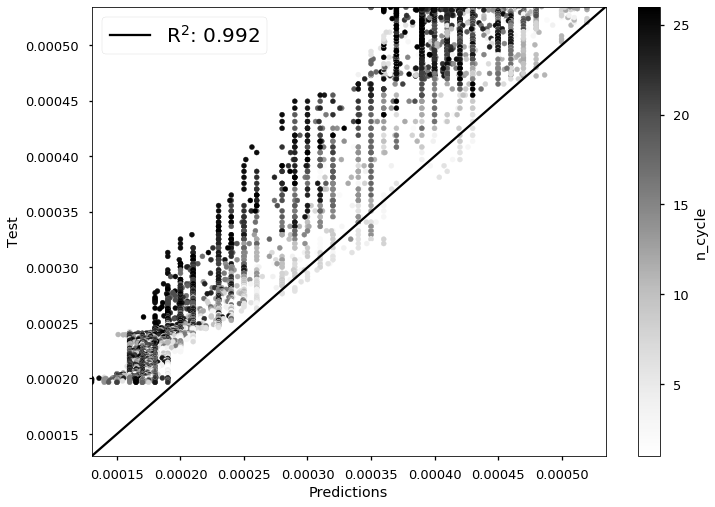

In [85]:
SAVE_PATH = "/home/emmanuel/figures/ml4ocn/"

r2_val = res.rsquared
slope = res.params[0]

min_lim = y_validation[['Predictions', 'Test']].min().min()
max_lim = y_validation[['Predictions', 'Test']].max().max()

plt.style.use('seaborn-talk')
fig, ax = plt.subplots()
y_validation.plot.scatter(ax=ax, x='Predictions', y='Test', c='n_cycle', s=25)
ax.plot(np.linspace(min_lim, max_lim), np.linspace(min_lim, max_lim), color='black', zorder=3)
plt.xlim([min_lim, max_lim])
plt.ylim([min_lim, max_lim])
plt.tight_layout()
plt.legend([fr'R$^2$: {r2_val:.3f}'], fontsize=20)
plt.savefig(SAVE_PATH + f'na_valid_m{model_name}_f{ifloat}_t' + '.png')
plt.show()

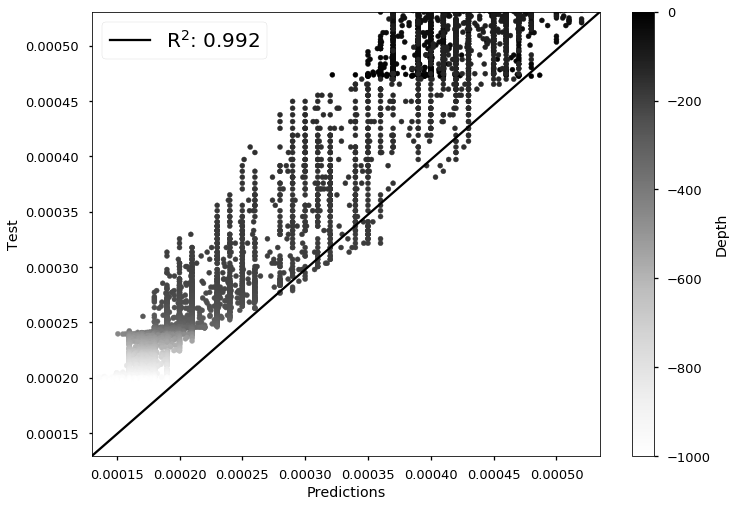

In [64]:
SAVE_PATH = "/home/emmanuel/figures/ml4ocn/"

xlim = y_validation[['Predictions']].min()
max_lim = y_validation[['Predictions', 'Test']].max()

plt.style.use('seaborn-talk')
fig, ax = plt.subplots()
y_validation.plot.scatter(ax=ax, x='Predictions', y='Test', c='Depth', s=25)
ax.plot(np.linspace(min_lim, max_lim), r2_val * np.linspace(min_lim, max_lim), color='black', zorder=3)
plt.xlim([min_lim, max_lim])
# plt.ylim([r2_val * min_lim, r2_val * max_lim])
plt.tight_layout()
plt.legend([fr'R$^2$: {r2_val:.3f}'], fontsize=20)
plt.savefig(SAVE_PATH + f'na_valid_m{model_name}_f{ifloat}_d' + '.png')
plt.show()

In [444]:
# each level
each_level = False

stats = get_stats(ypred, dataset['ytest'], each_level=each_level)

stats

,mae,mse,rmse,r2
0,0.0002,2.580603e-07,2.580603e-07,-0.53396


In [445]:
each_level = True

stats_df = get_stats(ypred, dataset['ytest'], each_level=each_level)

stats_df.head()

,mae,mse,rmse,r2
0,0.001149,0.000002,0.001466,-0.076087
1,0.001200,0.000002,0.001544,-0.081775
2,0.001238,0.000003,0.001606,-0.085894
3,0.001290,0.000003,0.001673,-0.091362
4,0.001343,0.000003,0.001753,-0.099165


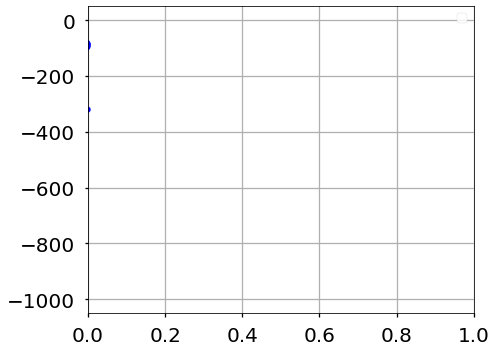

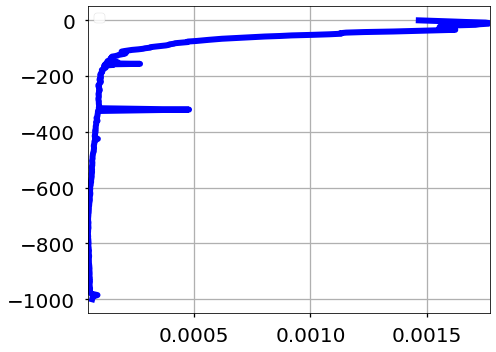

In [446]:
statistic = 'r2'
plt.style.use('seaborn-talk')
plot_mo_stats(stats_df, stat='r2', save_name='valid_mlp')
plot_mo_stats(stats_df, stat='rmse', save_name='valid_mlp')

---
### 7 - Post Analysis

#### 7.1 - Feature Importance

For some algorithms, we can calculate the feature importance based on the inputs dimensions. This is true for the random forest model.

In [135]:
rf_model.

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [39]:
tree_feature_importances = \
    rf_model.feature_importances_

feature_names = np.asarray(new_columns) #np.concatenate((core_columns.values, np.array(pca_columns)))

assert feature_names.shape[0] == tree_feature_importances.shape[0], "Shapes don't match"

sorted_idx = tree_feature_importances.argsort()

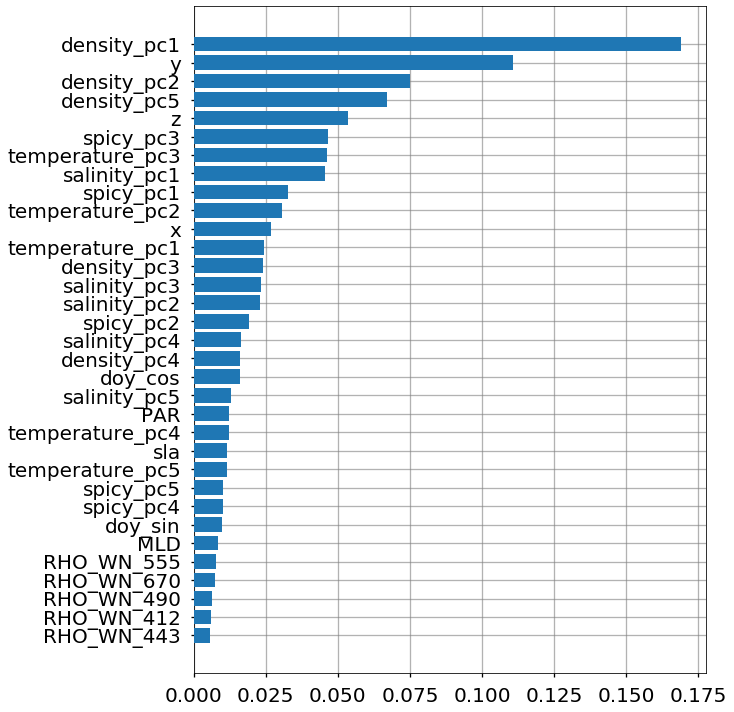

In [40]:
SAVE_PATH = "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/reports/figures/"
save_name = 'na'
y_ticks = np.arange(0, len(feature_names))
plt.style.use(['seaborn-talk'])
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(y_ticks, tree_feature_importances[sorted_idx], zorder=3, height=0.8)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
# ax.set_title("Random Forest Feature Importances (MDI)")
ax.tick_params(axis="both", which="major", labelsize=20)
ax.tick_params(axis="both", which="minor", labelsize=20)
ax.grid(alpha=0.6, color='gray', zorder=0)
plt.tight_layout()
plt.show()
# fig.savefig(SAVE_PATH + f"fi_{save_name}.png")

#### 7.2 - Permutation Plot

In [36]:
perm_result_test = permutation_importance(
    model, 
    dataset['Xtest'], 
    dataset['ytest'], 
    n_repeats=10,
    random_state=42, 
    n_jobs=1
)

In [37]:
sorted_idx = perm_result_test.importances_mean.argsort()

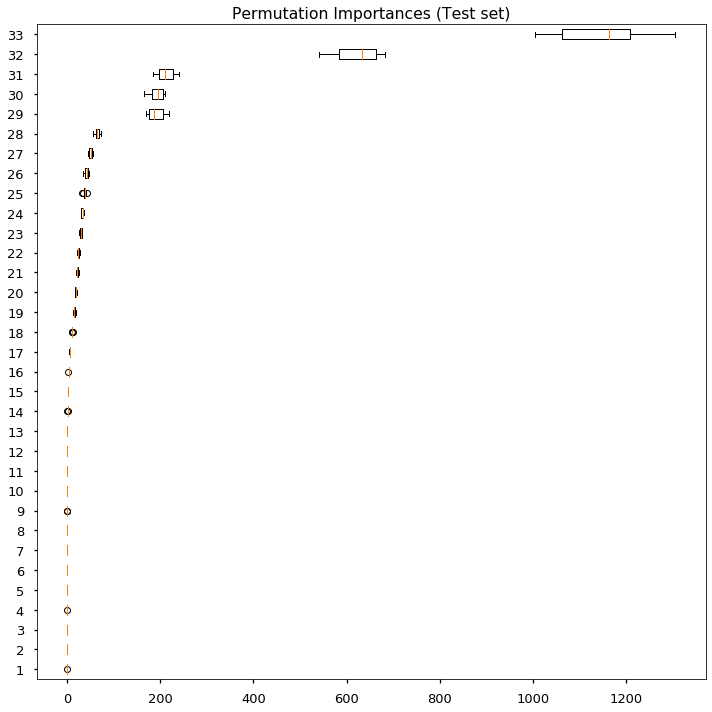

In [42]:
# feature_names = np.asarray(new_columns) 

fig, ax = plt.subplots(figsize=(10,10))
plt.style.use(['seaborn-talk'])
ax.boxplot(
    perm_result_test.importances[sorted_idx].T,
    vert=False, 
#     labels=feature_names[sorted_idx]
)
ax.set_title("Permutation Importances (Test set)")
fig.tight_layout()
plt.show()

In [38]:
perm_result_train = permutation_importance(
    rf_model, 
    Xtrain, 
    ytrain, 
    n_repeats=10,
    random_state=42, 
    n_jobs=1
)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 1500 out of 1500 | elapsed:    2.3s finished
/home/emmanuel/.conda/envs/ml4ocn/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", Futu

KeyboardInterrupt: 

In [ ]:
sorted_idx = perm_result_train.importances_mean.argsort()

NameError: name 'perm_result_train' is not defined

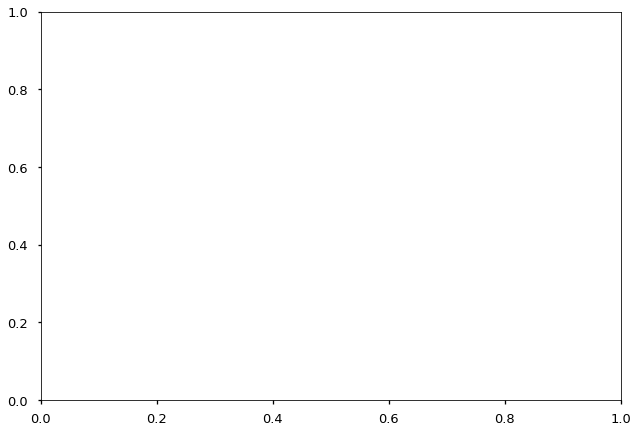

In [40]:
plt.style.use(['seaborn-talk'])
fig, ax = plt.subplots()
ax.boxplot(
    perm_result_train.importances[sorted_idx].T,
    vert=False, 
#     labels=feature_names[sorted_idx]
)
ax.set_title("Permutation Importances (Train set)")
fig.tight_layout()
plt.show()

#### Load Data

In [143]:
X_core = load_standard_data('STG', training=True)

# Testing Data
X_core_te = load_standard_data('STG', training=False)


X_core_te = X_core_te.iloc[:, 2:]

X_core.shape, X_core_te.shape

((1353, 11), (133, 11))

In [144]:
X_temp, X_dens, X_sal, X_spicy = load_high_dim_data('STG', training=True)

# add prefix (Training/Validation)
X_temp = X_temp.add_prefix('temp_')
X_dens = X_dens.add_prefix('dens_')
X_sal = X_sal.add_prefix('sal_')
X_spicy = X_spicy.add_prefix('spice_')

# 
X_temp_te, X_dens_te, X_sal_te, X_spicy_te = load_high_dim_data('STG', training=False)


# Subset
X_temp_te = X_temp_te.iloc[:, 2:] 
X_dens_te = X_dens_te.iloc[:, 2:] 
X_sal_te= X_sal_te.iloc[:, 2:]
X_spicy_te = X_spicy_te.iloc[:, 2:]

# add prefix (Test)
X_temp_te = X_temp_te.add_prefix('temp_')
X_dens_te = X_dens_te.add_prefix('dens_')
X_sal_te = X_sal_te.add_prefix('sal_')
X_spicy_te = X_spicy_te.add_prefix('spice_')

In [145]:
y = load_labels('STG', training=True)

yte = load_labels('STG', training=False)

yte = yte.iloc[:, 2:]


In [146]:
# Training Data
Xtr = pd.concat([
    X_core, 
    X_temp, 
    X_dens, 
    X_sal, 
    X_spicy
], axis=1)



# Testing Data
Xte = pd.concat([
    X_core_te, 
    X_temp_te, 
    X_dens_te, 
    X_sal_te, 
    X_spicy_te
], axis=1)

#### Tre Transformations

In [154]:
# new columns columns
temp_columns = X_temp.columns.values
dens_columns = X_dens.columns.values
sal_columns = X_sal.columns.values
spicy_columns = X_spicy.columns.values
core_columns = ['sla', "PAR","RHO_WN_412","RHO_WN_443","RHO_WN_490","RHO_WN_555","RHO_WN_670","MLD"]
time_columns = ['doy']
loc_columns = ['lat', 'lon']

n_components = 5
times = ['doy']

new_columns = [
    *["doy_cos", "doy_sin"], 
    *['x', 'y', 'z',],
    *[f"temperature_pc{icomponent+1}" for icomponent in range(n_components)],
    *[f"density_pc{icomponent+1}" for icomponent in range(n_components)],
    *[f"salinity_pc{icomponent+1}" for icomponent in range(n_components)],
    *[f"spicy_pc{icomponent+1}" for icomponent in range(n_components)],
    *core_columns, 
]
seed = 123
# define transfomer
X_transformer = ColumnTransformer(
    [   ("time", CycleTransform(times), time_columns),
        ("space", GeoCartTransform(), loc_columns),
        ('temp', PCA(n_components=n_components, random_state=seed), temp_columns),
        ('dens', PCA(n_components=n_components, random_state=seed), dens_columns),
        ('sal', PCA(n_components=n_components, random_state=seed), sal_columns),
        ('spice', PCA(n_components=n_components, random_state=seed), spicy_columns),
#         ('core', StandardScaler(with_mean=True, with_std=True), core_columns)
    ],
    remainder='passthrough'
)
# fit transform to data
X_transformer.fit(Xtr)

# transform data
Xtrain = X_transformer.fit_transform(Xtr)
Xtest = X_transformer.transform(Xte)

In [155]:
ytrain = np.log(y)
ytest = np.log(yte)

ytrain.shape, ytest.shape

((1353, 276), (133, 276))

#### Train-Test Split

In [156]:
Xtrain, Xvalid, ytrain, yvalid =  train_test_split(
        Xtrain, ytrain,
        train_size=.8, random_state=1
    )


#### Post Transformations

In [157]:
X_transformer = StandardScaler(with_mean=True, with_std=True)

# fit transform to data
X_transformer.fit(Xtrain)

# transform data
Xtrain = X_transformer.fit_transform(Xtrain)
Xvalid = X_transformer.transform(Xvalid)
Xtest = X_transformer.transform(Xtest)

In [158]:
output_transformer = StandardScaler(with_mean=True, with_std=False)

ytrain = output_transformer.fit_transform(ytrain)
yvalid = output_transformer.fit_transform(yvalid)
ytest = output_transformer.transform(ytest)

#### Train ML Model

In [159]:
model = train_mlp_model(Xtrain, ytrain, verbose=1, valid=0.1)

Iteration 1, loss = 0.04404014
Iteration 2, loss = 0.04233716
Iteration 3, loss = 0.03999879
Iteration 4, loss = 0.03553489
Iteration 5, loss = 0.02922904
Iteration 6, loss = 0.02270823
Iteration 7, loss = 0.01774804
Iteration 8, loss = 0.01455149
Iteration 9, loss = 0.01275994
Iteration 10, loss = 0.01139479
Iteration 11, loss = 0.01041543
Iteration 12, loss = 0.00956958
Iteration 13, loss = 0.00893924
Iteration 14, loss = 0.00837105
Iteration 15, loss = 0.00784597
Iteration 16, loss = 0.00745897
Iteration 17, loss = 0.00710062
Iteration 18, loss = 0.00689064
Iteration 19, loss = 0.00659195
Iteration 20, loss = 0.00644984
Iteration 21, loss = 0.00620834
Iteration 22, loss = 0.00599103
Iteration 23, loss = 0.00585093
Iteration 24, loss = 0.00571502
Iteration 25, loss = 0.00557472
Iteration 26, loss = 0.00544984
Iteration 27, loss = 0.00532607
Iteration 28, loss = 0.00522278
Iteration 29, loss = 0.00508456
Iteration 30, loss = 0.00503143
Iteration 31, loss = 0.00501642
Iteration 32, los

#### Test ML Model

In [103]:
ypred = model.predict(Xtest)
# each level
each_level = False

stats = get_stats(ypred, ytest, each_level=each_level)

stats

,mae,mse,rmse,r2
0,0.076336,0.011636,0.011636,0.812559


In [104]:
each_level = True

stats_df = get_stats(ypred, ytest, each_level=each_level)

stats_df.head()

,mae,mse,rmse,r2
0,0.088556,0.020310,0.142513,0.717452
1,0.081911,0.015445,0.124277,0.762677
2,0.076586,0.011129,0.105496,0.814074
3,0.081023,0.013181,0.114808,0.789395
4,0.073182,0.009919,0.099596,0.820807


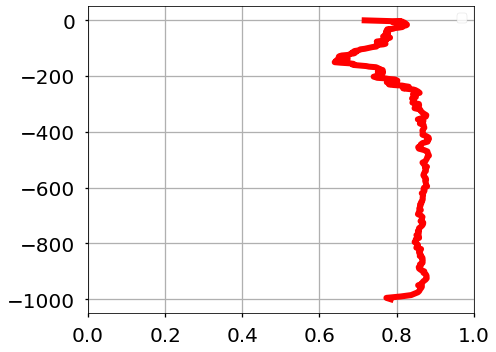

In [109]:
statistic = 'r2'
plt.style.use('seaborn-talk')
plot_mo_stats(
    stats_df, 
    stat='r2', 
    save_name='stg_test',
    color='red'
)

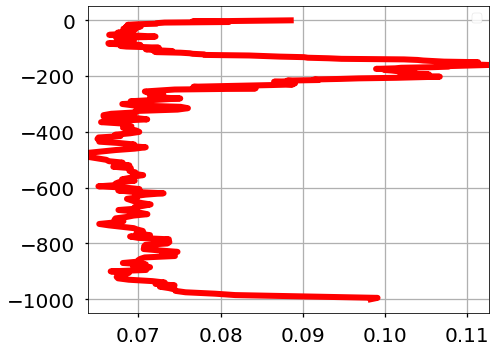

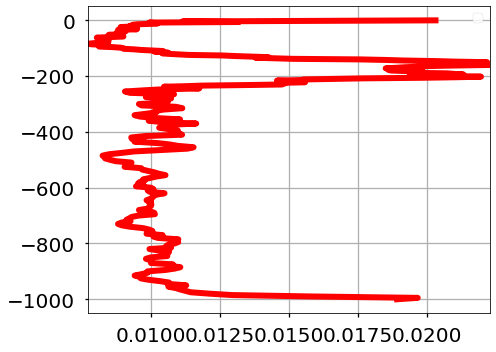

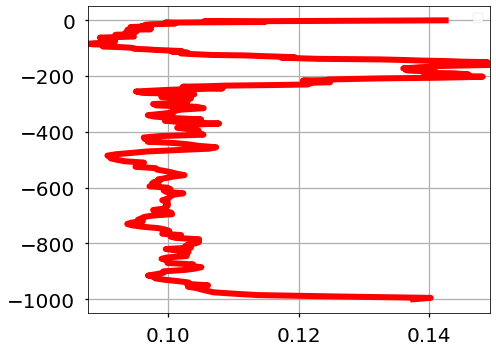

In [110]:
plot_mo_stats(stats_df, stat='mae', save_name='stg_test', color='red')
plot_mo_stats(stats_df, stat='mse', save_name='stg_test', color='red')
plot_mo_stats(stats_df, stat='rmse', save_name='stg_test', color='red')

#### Post Analysis

In [53]:
tree_feature_importances = \
    rf_model.feature_importances_

feature_names = np.asarray(new_columns) #np.concatenate((core_columns.values, np.array(pca_columns)))

assert feature_names.shape[0] == tree_feature_importances.shape[0], "Shapes don't match"

sorted_idx = tree_feature_importances.argsort()

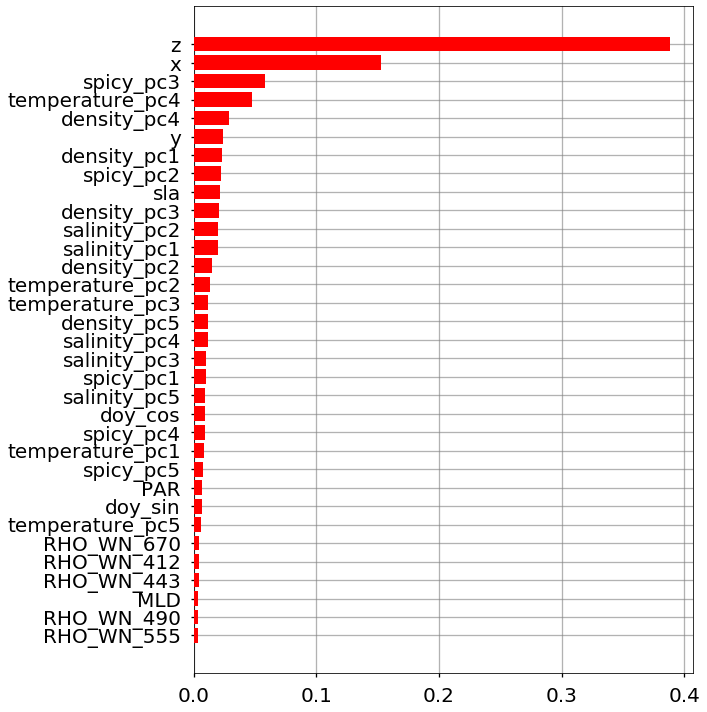

In [54]:
SAVE_PATH = "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/reports/figures/"
save_name = 'stg'
y_ticks = np.arange(0, len(feature_names))
plt.style.use(['seaborn-talk'])
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(y_ticks, tree_feature_importances[sorted_idx], zorder=3, height=0.8, color='red')
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
# ax.set_title("Random Forest Feature Importances (MDI)")
ax.tick_params(axis="both", which="major", labelsize=20)
ax.tick_params(axis="both", which="minor", labelsize=20)
ax.grid(alpha=0.6, color='gray', zorder=0)
plt.tight_layout()
plt.show()
fig.savefig(SAVE_PATH + f"fi_{save_name}.png")

In [105]:
depths = 276
first = [*range(1, 250)]
d1 = first[::2]

second = [*range(251,1000)]
d2 = second[::5]


In [106]:
len(d1), len(d2)

(125, 150)

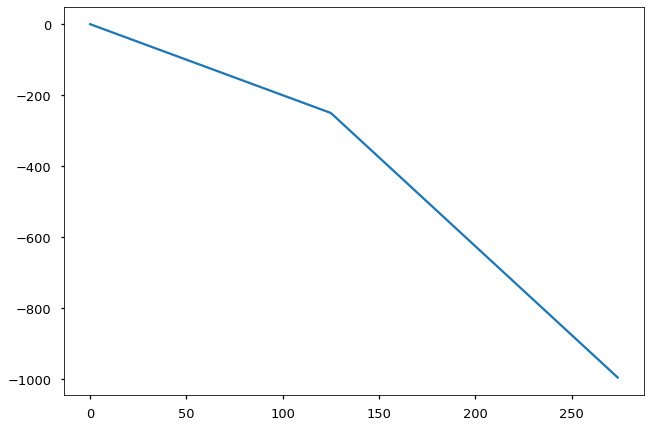

In [109]:
plt.plot(-np.concatenate((d1,d2)))